In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
import numpy as np
from scipy.stats import norm
from scipy.spatial import distance

import matplotlib
import matplotlib.pyplot as plt

from gpytorch.priors import NormalPrior

from tqdm.notebook import tqdm

# Full Shape Sampling

## Sampling Function

In [2]:
def create_samples(circle_center_x, rec_long_side, rec_short_side, points_per_unit=100):
    diff_x = circle_center_x - (rec_long_side/2)
    assert diff_x > 0
    
    circle_radius = distance.euclidean([circle_center_x,0], [rec_long_side/2,rec_short_side/2])
    
    angle = np.arccos((circle_center_x - rec_long_side/2.0)/circle_radius)
    add_angle = 1/(points_per_unit*circle_radius)
    circle_perimeter = 4 * (np.pi - angle) * circle_radius
    rec_perimeter = 2 * rec_long_side
    total_perimeter = circle_perimeter + rec_perimeter
    
    dumbbell_samples = torch.empty((int(points_per_unit * total_perimeter), 2), dtype=torch.float32)
    samples_till_now = 0
    rec_sample = int(rec_perimeter * points_per_unit/2)
    circle_sample = int(circle_perimeter * points_per_unit/2)
    
    for i in range(rec_sample):
        dumbbell_samples[i] = torch.Tensor([-rec_long_side/2 + i/points_per_unit, rec_short_side/2])
    samples_till_now+=rec_sample
    
    starting_angle = np.pi - angle
    for j in range(circle_sample):
        new_angle = starting_angle - j*add_angle
        dumbbell_samples[samples_till_now+j] = torch.Tensor([circle_center_x+circle_radius*np.cos(new_angle), circle_radius*np.sin(new_angle)])
    samples_till_now+=circle_sample
    
    for i in range(rec_sample):
        dumbbell_samples[samples_till_now+i] = torch.Tensor([rec_long_side/2 - i/points_per_unit, -rec_short_side/2])
    samples_till_now+=rec_sample
    
    starting_angle = angle
    for j in range(circle_sample):
        new_angle = starting_angle + j*add_angle
        dumbbell_samples[samples_till_now+j] = torch.Tensor([-circle_center_x+circle_radius*np.cos(new_angle), circle_radius*np.sin(new_angle)])
    samples_till_now+=circle_sample
    
    full_circles_perimeter = 4 * np.pi * circle_radius
    eye_samples = torch.empty((int(points_per_unit * full_circles_perimeter), 2), dtype=torch.float32)
    
    full_circle_sample = int(full_circles_perimeter * points_per_unit/2)
    
    for i in range(full_circle_sample):
        eye_samples[i] = torch.Tensor([-circle_center_x+circle_radius*np.cos(i*add_angle), circle_radius*np.sin(i*add_angle)])
        eye_samples[full_circle_sample+i] = torch.Tensor([circle_center_x+circle_radius*np.cos(i*add_angle), circle_radius*np.sin(i*add_angle)])
    
    return dumbbell_samples[0:samples_till_now], eye_samples, circle_radius


## Creating Grid

In [3]:
def create_grid(sampled, eps=0.1, res=0.01):
    dims = len(sampled.shape)
    
    borders = torch.empty((dims, 2), dtype=torch.float32)
    for i in range(dims):
        borders[i, 0] = min(sampled[:,i]) - eps
        borders[i, 1] = max(sampled[:,i]) + eps
        
    grid_sizes = torch.empty(dims, dtype=torch.int32)
    for i in range(dims):
        grid_sizes[i] = (borders[i, 1] - borders[i, 0])/res + 1
        
    grid_points = torch.empty((torch.prod(grid_sizes).int(), 2), dtype=torch.float32)
    if (dims==2):
        for x in range(grid_sizes[0]):
            for y in range(grid_sizes[1]):
                index = (x * grid_sizes[1]) + y
                grid_points[index] = torch.Tensor([borders[0, 0] + x * res, borders[1, 0] + y * res])
    return grid_points, grid_sizes

## Computing Unsigned Distance

In [4]:
def distance_from_circle(circle_center, circle_radius, pt):
    return distance.euclidean(pt, circle_center)-circle_radius
    
def udf_dumbbell_pt(circle_center_x, rec_long_side, rec_short_side, circle_radius, pt):
    diff_x = circle_center_x - (rec_long_side/2)
    assert diff_x > 0
    
    circle_center = np.array([circle_center_x, 0])
    x, y = pt

    if -rec_long_side/2 <= x <= rec_long_side/2:
        if -rec_short_side/2 <= y <= rec_short_side/2:
            return min(torch.abs(rec_short_side/2 -y), torch.abs(y+rec_short_side/2))
        else:
            if x < 0:
                circle_center = -circle_center
            if y >= rec_short_side/2:
                return min(y-rec_short_side/2, distance_from_circle(circle_center, circle_radius, pt))
            else:
                return min(-y-rec_short_side/2, distance_from_circle(circle_center, circle_radius, pt))    
    else:
        if x < 0:
                circle_center = -circle_center
        return np.abs(distance_from_circle(circle_center, circle_radius, pt))

def udfs_from_dumbbell(circle_center_x, rec_long_side, rec_short_side, circle_radius, points):
    udf_pts = torch.empty(points.size()[0], dtype=torch.float32)
    for i in range(udf_pts.size()[0]):
        udf_pts[i] = udf_dumbbell_pt(circle_center_x, rec_long_side, rec_short_side, circle_radius, points[i])
    return udf_pts

def udfs_from_eye(circle_center_x, circle_radius, points):
    udf_pts = torch.empty(points.size()[0], dtype=torch.float32)
    rc = np.array([circle_center_x, 0])
    lc = -rc
    for i in range(udf_pts.size()[0]):
        udf_pts[i] = min(np.abs(distance_from_circle(lc, circle_radius, points[i])), np.abs(distance_from_circle(rc, circle_radius, points[i])))
    return udf_pts
    

## Plotting

In [5]:
def get_sample_plot(samples):
    with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(samples.cpu().numpy()[:, 0], samples.cpu().numpy()[:, 1], s = 0.1)
        ax.axis('equal')
        ax.set_title(f'Samples on the Surface')
        
def get_udf_plot(grid_points, udfs_grid):
    with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(grid_points.cpu().numpy()[:, 0], grid_points.cpu().numpy()[:, 1], c=udfs_grid.cpu().numpy(),s = 0.1)
        fig.colorbar(plot)
        ax.axis('equal')
        ax.legend_ = None
        ax.set_title(f'Grid Points with UDF')
        
def get_plots(samples, grid_points, udf, plot_samples=True, plot_udf=True):
    if plot_samples:
        get_sample_plot(samples)
    if plot_udf:
        get_udf_plot(grid_points, udf)
        

In [6]:
def initiate_shapes(circle_center_x, rec_long_side, rec_short_side, points_per_unit, plot_samples=True, plot_udf=True):
    dumbbell_samples, eye_samples, circle_radius = create_samples(circle_center_x, rec_long_side, rec_short_side, points_per_unit)
    grid_points, grid_sizes = create_grid(dumbbell_samples)
    grid_udfs_dumbbell = udfs_from_dumbbell(circle_center_x, rec_long_side, rec_short_side, circle_radius, grid_points)
    grid_udfs_eye = udfs_from_eye(circle_center_x, circle_radius, grid_points)
    get_plots(dumbbell_samples, grid_points, grid_udfs_dumbbell, plot_samples, plot_udf)
    get_plots(eye_samples, grid_points, grid_udfs_eye, plot_samples, plot_udf)
    
    return dumbbell_samples, eye_samples, grid_points, grid_udfs_dumbbell, grid_udfs_eye, grid_sizes
    

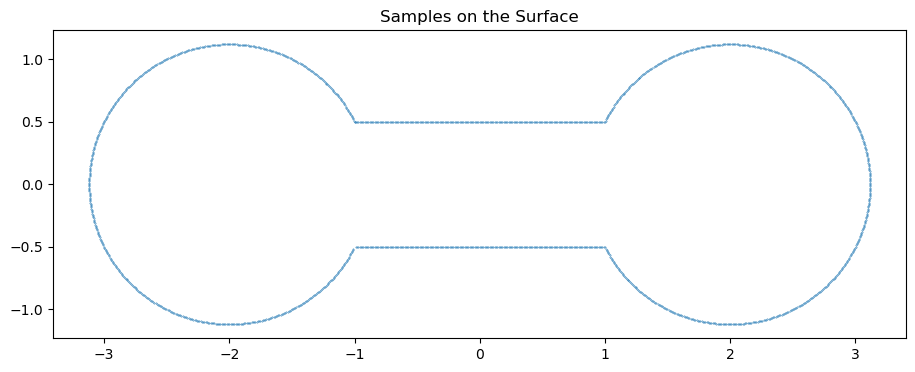

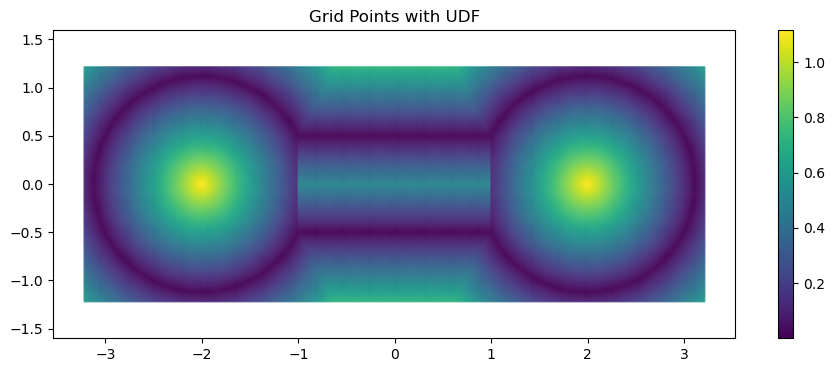

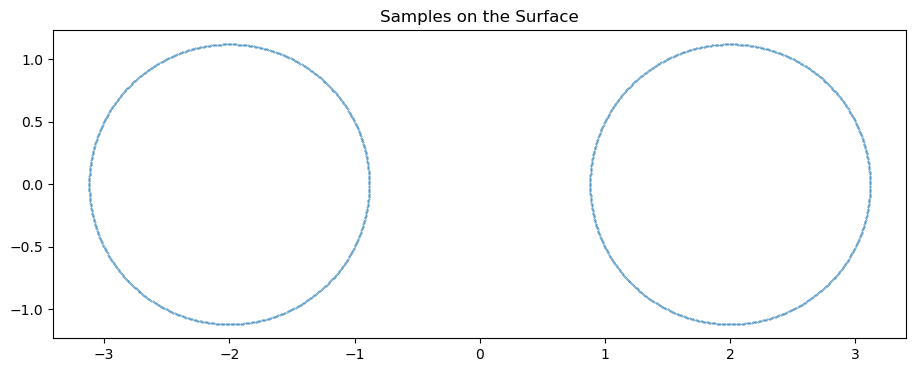

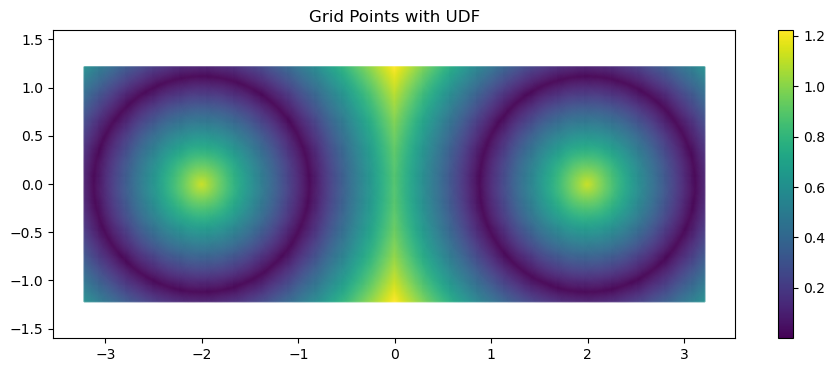

In [7]:
# one example
cr, rl, rs = 2.0, 2.0, 1.0
ds, es, gp, gdd, gde, gs = initiate_shapes(cr, rl, rs, 100)

# Subsampling Circular Parts

In [8]:
def subsample_eye(eye_samples, percent_to_keep):
    full_sample_size = eye_samples.size(0)
    half_sample_size = full_sample_size/2
    throw = (100.0 - percent_to_keep)/100.0
    half_throw = half_sample_size*throw/2
    half_keep = half_sample_size*percent_to_keep/200.0
    subsample_indices_l = np.arange(half_throw, half_sample_size-half_throw, 1)
    subsample_indices_r = np.concatenate((half_sample_size + np.arange(half_keep), np.arange(full_sample_size-half_keep, full_sample_size, 1)))
    subsample_indices = np.concatenate((subsample_indices_l, subsample_indices_r))
    
    return eye_samples[subsample_indices]
    

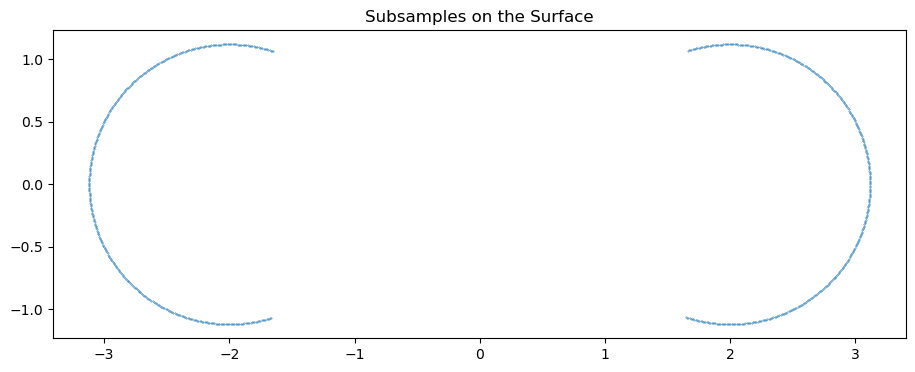

In [9]:
# example
ess = subsample_eye(es, 60)
with torch.no_grad():
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(ess.cpu().numpy()[:, 0], ess.cpu().numpy()[:, 1], s = 0.1)
    ax.axis('equal')
    ax.set_title(f'Subsamples on the Surface')

# Building the Network

## PointNet

### TNet

In [10]:
class TNet(nn.Module):
    ''' For learning a Transformation matrix with a specified dimension '''
    def __init__(self, dim, num_points):
        super(TNet, self).__init__()

        # dimensions for transformation matrix
        self.dim = dim 

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)

    def forward(self, x):
        bs = x.shape[0]

        # forward through conv1d (shared MLP) layers
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over number of input points
        x = self.max_pool(x).view(bs, -1)
        
        # pass through fully connected (linear) layers
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x

### Global Encoder

In [11]:
class PointNetEncoder(nn.Module):
    def __init__(self, input_points, input_dim, dim_global_feature):
        ''' Initializers:
                input_points - number of points in input point cloud
                input_dim - dimension of input point space
                dim_global_feature - dimension of Global Features for the main 
                                   Max Pooling layer
            '''
        super(PointNetEncoder, self).__init__()
        
        self.input_points = input_points
        self.input_dim = input_dim
        self.dim_global_feature = dim_global_feature

        # TNets
        self.tnet_input = TNet(dim=input_dim, num_points=input_points)
        self.tnet_inter = TNet(dim=64, num_points=input_points)

        # conv1d (shared MLP) before feature transform
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # conv1d (shared MLP) after feature transform
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.dim_global_feature, kernel_size=1)
        
        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.dim_global_feature)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=input_points, return_indices=True)

        
    def forward(self, x):
        # get batch size
        bs = x.shape[0]
        
        # pass through first Tnet to get transformation matrix
        T_input = self.tnet_input(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), T_input).transpose(2, 1)

        # pass through first 1d convnets
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        
        # compute feature transform
        T_feature = self.tnet_inter(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), T_feature).transpose(2, 1)

        # pass through second set of 1d convnets
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector and critical indexes
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        return global_features, critical_indexes, T_feature


## GPyTorch DKL

### Input Mapper for Kernel

In [12]:
class KernelMapper(torch.nn.Sequential):
    def __init__(self, input_data_dim, output_data_dim):
        super(KernelMapper, self).__init__()
        self.add_module('linear1', torch.nn.Linear(input_data_dim, 32))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(32, 64))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(64, 128))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(128, output_data_dim))
        

### GP Regression

#### Conditioning Before Projection

In [13]:
class GPRegressionModelB(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, input_data_dim, kernel_map):
        super(GPRegressionModelB, self).__init__(train_x, train_y, likelihood)

        # prior mean and covariance
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=input_data_dim))
        self.kernel_mapper = kernel_map

        # This module will scale the NN features
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):
        # we're first putting our data through an NN
        projected_x = self.kernel_mapper(x)
        projected_x = self.scale_to_bounds(projected_x)
        
        # posterior mean and covariance from Gaussian Process
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [23]:
ess

tensor([[-1.6498,  1.0618],
        [-1.6593,  1.0649],
        [-1.6688,  1.0679],
        ...,
        [ 3.1175, -0.0348],
        [ 3.1178, -0.0248],
        [ 3.1179, -0.0148]])

In [27]:
ess.unsqueeze(0).repeat((2,1,1)).transpose(1,2)

tensor([[[-1.6498, -1.6593, -1.6688,  ...,  3.1175,  3.1178,  3.1179],
         [ 1.0618,  1.0649,  1.0679,  ..., -0.0348, -0.0248, -0.0148]],

        [[-1.6498, -1.6593, -1.6688,  ...,  3.1175,  3.1178,  3.1179],
         [ 1.0618,  1.0649,  1.0679,  ..., -0.0348, -0.0248, -0.0148]]])

##### Training

In [14]:
def get_result(shape1_x, shape2_x, shape1_y, shape2_y, subsample, projection_dim, training_loops, training_iterations, learning_rate=0.001):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    ss_repeat = 2
    
    for i in range(training_loops):
        train_x = shape1_x.contiguous().to(device)
        train_y = shape1_y.contiguous().to(device)
        choice = random.choice([0, 1])
        if choice==1:
            train_x = shape2_x.contiguous().to(device)
            train_y = shape2_y.contiguous().to(device)
        ss = subsample.unsqueeze(0).repeat((2,1,1)).to(device)
        train_enc_repeat = int(train_x.size(0) / ss_repeat)
    
        init_input_dim = train_x.size(-1)
        encoder = PointNetEncoder(subsample.size(0), subsample.size(1), 1024)
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        kernel_map = KernelMapper(init_input_dim, projection_dim)
        model = GPRegressionModelB(train_x, train_y, likelihood, projection_dim, kernel_map)

        if torch.cuda.is_available():
            model = model.cuda()
            encoder = encoder.cuda()
            likelihood = likelihood.cuda()

        # Find optimal model hyperparameters
        model.train()
        encoder.train()
        likelihood.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam([
            {'params': model.kernel_mapper.parameters()},
            {'params': model.covar_module.parameters()},
            {'params': model.mean_module.parameters()},
            {'params': model.likelihood.parameters()},
            {'params': encoder.parameters()},
        ], lr=learning_rate)

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        iterator = tqdm(range(training_iterations))
        for i in iterator:
            # Zero backprop gradients
            optimizer.zero_grad()
            #Get encoding from encoder
            encoding, critical_indexes, T_feature = encoder(ss.transpose(1,2))
            #enc = encoding.repeat((train_enc_repeat, 1))
            #conditioned_x = torch.concatenate((enc, train_x), dim=1)
            # Get output from model
            output = model(train_x)
            # Calc loss and backprop derivatives
            loss = -mll(output, train_y)
            loss.backward()
            iterator.set_postfix(loss=loss.item())
            optimizer.step()


    return model, encoder

In [15]:
# example
dsy = torch.zeros(ds.size(0))
esy = torch.zeros(es.size(0))
model, encoder = get_result(ds, es, dsy, esy, ess, 256, 10, 5, learning_rate=0.001)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

#### Conditioning After Projection

In [121]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
grid_points = gp.to(device)
grid_sizes = gs.to(device)

In [135]:
def plot_on_surface_with_var(predictions, grid_points, grid_sizes):
    prob_on_surface = norm.pdf(np.zeros(predictions.mean.shape),loc=predictions.mean.cpu(),scale=predictions.stddev.cpu())
    
    gp = grid_points.cpu().numpy()
    gp_x = gp[:, 0].reshape(grid_sizes.cpu().numpy())
    gp_y = gp[:, 1].reshape(grid_sizes.cpu().numpy())
    gp_prob = prob_on_surface.reshape(grid_sizes.cpu().numpy())
    
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.pcolormesh(gp_x, gp_y, gp_prob, shading='gouraud',cmap='Greys')
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title(f'Probability of being on the surface')

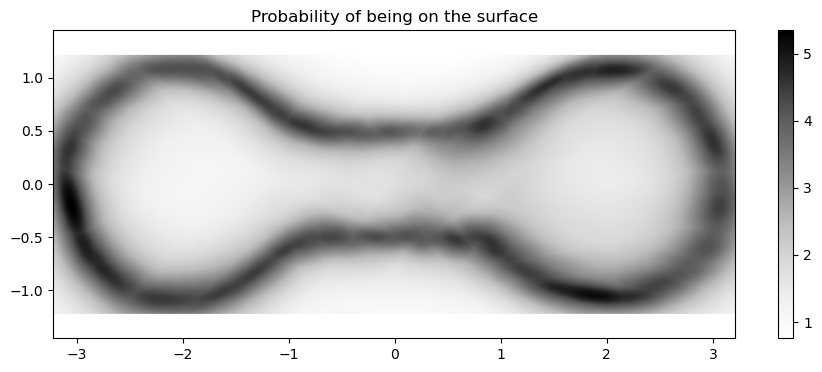

In [150]:
model.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    grid_preds = model(grid_points)
plot_on_surface_with_var(grid_preds, grid_points, grid_sizes)

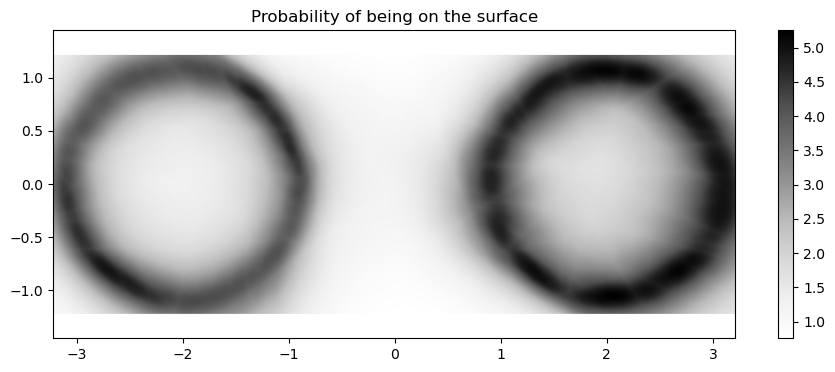

In [146]:
model.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    grid_preds = model(grid_points)
plot_on_surface_with_var(grid_preds, grid_points, grid_sizes)